# Tensorflow Practice

This notebook contains our practice work in training a neural network to do binary classification.


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import random
import pandas
from sklearn.metrics.pairwise import pairwise_distances
import numpy as np
import matplotlib.pyplot as plt

Run this python file to generate all the datasets used:

In [3]:
%run -i 'build_simple_example.py'

In [4]:
# These tests are all binary classifiers, so the number of labels = 2
num_labels = 2

In [5]:
# Use the method to draw the image
def draw_image(x_data):
    x_0 = []
    x_1 = []
    y_0 = []
    y_1 = []

    for row in x_data:
        x = row[2]
        y = row[3]
        color = row[4]
        if color == 0:
            x_0.append(x)
            y_0.append(y)
        else:
            x_1.append(x)
            y_1.append(y)

    plt.scatter(x_0, y_0, c = "red")
    plt.scatter(x_1, y_1, c = "blue")

    plt.axis('equal')
    plt.show()

In [6]:
def generate_dataset(filename):
    col_names = ['ts','user','x_coordinate','y_coordinate','color', 'label']
    data = pandas.read_csv(filename, names = col_names, header=None, skiprows=1)

    return data

In [7]:
def extract_data(filename, num_labels):
    data = generate_dataset(filename)
    dim = data.ts.values.shape[0]
    dataset_x = np.concatenate((data.ts.values.reshape(dim,1),
                              data.user.values.reshape(dim,1),
                              data.x_coordinate.values.reshape(dim,1),
                              data.y_coordinate.values.reshape(dim,1),
                              data.color.values.reshape(dim,1)), axis=1)
    dataset_y = np.zeros((dim,num_labels))
    for i in range(dim):
        dataset_y[i][data.label.values[i]] = 1
    return dataset_x, dataset_y, dataset_x.shape[0]

In [8]:
def create_training_and_testing_sets(x_data, y_data, shape, num_test_points):
    test_indexes = random.sample(range(0, shape), num_test_points )


    train_indexes = np.setdiff1d(list(range(0,shape)),test_indexes)
    train_x = x_data[train_indexes]
    train_y = y_data[train_indexes]

    test_x = x_data[test_indexes]
    test_y = y_data[test_indexes]

    return train_x, train_y, test_x, test_y

When we built our model, we tried a lot of different things.
For our weights, we randomly assigned them based on a normal distribution with a standard deviation of 0.01. We tried changing this standard deviation and found the best result was with 0.01 but it was not a very significant accuracy improvement. We also tried adding a second hidden layer, but it did not change the accuracy.

In [97]:
def build_model():
    x = tf.placeholder(tf.float32, shape=(None, 5), name='x')    
    y = tf.placeholder(tf.float32, shape=(None, num_labels), name='y') 
    
    W1 = tf.Variable(tf.abs(tf.random_normal([5, 4], stddev = 0.01), name='W1'))
    b1 = tf.Variable(tf.random_normal([4], stddev = 0.01), name='b1')
    
    W2 = tf.Variable(tf.random_normal([4, 4], stddev = 0.01), name='W2')
    b2 = tf.Variable(tf.random_normal([4], stddev = 0.01), name='b2')
    
    W_out = tf.Variable(tf.random_normal([4, num_labels], stddev=0.01), name='W_out')
    b_out = tf.Variable(tf.random_normal([num_labels], stddev = 0.01), name='b_out')

    
    hidden_out = tf.add(tf.matmul(x, W1), b1)
    #hidden_out = tf.nn.relu(hidden_out)
    
    hidden_out2 = tf.add(tf.matmul(hidden_out, W2), b2)
    #hidden_out2 = tf.nn.relu(hidden_out2)
    
    logits = tf.add(tf.matmul(hidden_out2, W_out), b_out)
    prediction = tf.nn.softmax(logits)
    y_clipped = tf.clip_by_value(prediction, 1e-10, 0.9999999)
    
    loss = -tf.reduce_mean((tf.reduce_sum(y * tf.log(y_clipped) + (1 - y) * tf.log(1 - y_clipped), axis=1)))
    
    train_op = tf.train.GradientDescentOptimizer(learning_rate = 0.01).minimize(loss)
    init = tf.global_variables_initializer()

    correct_prediction = tf.equal(tf.argmax(prediction, 1, name="Argmax_Pred"), tf.argmax(y, 1, name="Y_Pred"), name="Correct_Pred")
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32, name="Cast_Corr_Pred"), name="Accuracy")
    
    return x, y, init, train_op, loss, accuracy, prediction

In [39]:
def run(x, y, init, train_op, loss, accuracy, train_x, train_y, test_x, test_y, prediction):

    with tf.Session() as sess:
        sess.run(init)
        feed_dict = {x: train_x, y: train_y}
        test_dict = {x: test_x, y: test_y}
        
        error_increases = 0
        old_loss = 0
        for i in range(2000):
            #print('EPOCH', i)
            _, loss_val = sess.run([train_op, loss], feed_dict)
            
            if i % 1000 == 0:
                print("loss:", loss_val)
        
        print("Training Accuracy:", sess.run( accuracy, feed_dict))
        print("Testing Accuracy:", sess.run( accuracy, test_dict))
        #print(prediction)
        #print(prediction.eval(feed_dict = {x: test_x}))
        '''
        for i in range(0, len(tf.trainable_variables())):
            print((tf.trainable_variables())[i])
            print((tf.trainable_variables())[i].eval())
            print()
            print()            
            print()            
            print()  
        '''
        return list(prediction.eval(feed_dict = {x: test_x}))

In [11]:
def draw_prediction(x_data, prediction):
    modified_x = x_data
    dim = len(prediction)
    print(dim)
    for i in range(dim):
        modified_x[i][4] = np.argmax(prediction[i])
#         np.append(modified_x, [np.argmax(prediction[i])])
    
    print(modified_x)
    draw_image(modified_x)

The first dataset tested is two solid colored blocks placed to the left and the right of each other. The image is 100x100 pixels.

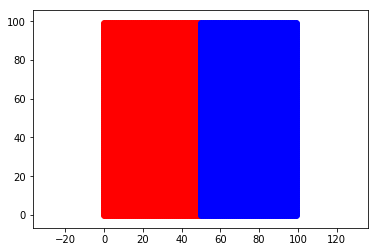

In [11]:
data_x, data_y, shape = extract_data('two_blocks_lr.txt', num_labels)

# Randomly take 9000 pixels to test on. The training set is only 1000
train_x, train_y, test_x, test_y = create_training_and_testing_sets(data_x, data_y, shape, 9000)
draw_image(data_x)

First, we trained and ran the data on the entire dataset, then tested on the entire dataset. We ran 2000 Epochs and printed the loss every 1000 epochs.
We did this 20 times.

In [12]:
for i in range(1):
    print("Iteration: ", i )
    x, y, init, train_op, loss, accuracy, prediction = build_model()
    run(x, y, init, train_op, loss, accuracy, data_x, data_y, data_x, data_y, prediction)
    

Iteration:  0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
loss: 1.3138673
loss: 0.40285686
Training Accuracy: 0.9834
Testing Accuracy: 0.9834
Iteration:  1
loss: 1.3795977
loss: 0.4107583
Training Accuracy: 0.9097
Testing Accuracy: 0.9097
Iteration:  2
loss: 1.3984808
loss: 0.41163695
Training Accuracy: 0.9122
Testing Accuracy: 0.9122
Iteration:  3
loss: 1.3513399
loss: 0.40976068
Training Accuracy: 0.9114
Testing Accuracy: 0.9114
Iteration:  4
loss: 1.3914944
loss: 0.40904132
Training Accuracy: 0.9108
Testing Accuracy: 0.9108
Iteration:  5
loss: 1.3776042
loss: 0.40500522
Training Accuracy: 0.9835
Testing Accuracy: 0.9835
Iteration:  6
loss: 1.4004954
loss: 0.40995932
Training Accuracy: 0.9086
Testing Accuracy: 0.9086
Iteration:  7
loss: 1.393941
loss: 0.40375465
Training Accuracy: 0.984
Testing Accuracy: 0.984
Iteration:  8
loss: 1.3735456
loss: 0.40601766
Training Accuracy: 0.984
Testing Accuracy: 0.984
Iter

Aftwards, we extracted 9000 datapoints for testing and trained on 1000

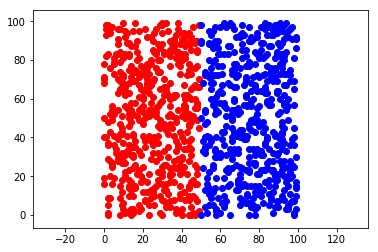

In [13]:
draw_image(train_x)

In [14]:
for i in range(20):
    print("Iteration: ", i )
    x, y, init, train_op, loss, accuracy, prediction = build_model()
    run(x, y, init, train_op, loss, accuracy, train_x, train_y, test_x, test_y, prediction)

Iteration:  0
loss: 1.4159116
loss: 0.39862922
Training Accuracy: 0.911
Testing Accuracy: 0.917
Iteration:  1
loss: 1.3779237
loss: 0.3940402
Training Accuracy: 0.982
Testing Accuracy: 0.9778889
Iteration:  2
loss: 1.378389
loss: 0.39460242
Training Accuracy: 0.982
Testing Accuracy: 0.97744447
Iteration:  3
loss: 1.3789707
loss: 0.3935081
Training Accuracy: 0.982
Testing Accuracy: 0.9776667
Iteration:  4
loss: 1.4004109
loss: 0.40027794
Training Accuracy: 0.909
Testing Accuracy: 0.9161111
Iteration:  5
loss: 1.365199
loss: 0.39400104
Training Accuracy: 0.982
Testing Accuracy: 0.9761111
Iteration:  6
loss: 1.360635
loss: 0.392596
Training Accuracy: 0.982
Testing Accuracy: 0.978
Iteration:  7
loss: 1.3777261
loss: 0.39381084
Training Accuracy: 0.982
Testing Accuracy: 0.9773333
Iteration:  8
loss: 1.4058796
loss: 0.3987022
Training Accuracy: 0.908
Testing Accuracy: 0.9152222
Iteration:  9
loss: 1.37722
loss: 0.39268312
Training Accuracy: 0.986
Testing Accuracy: 0.98044443
Iteration:  10
l

Next we also tested with the two colors on top of each other and on two opposite sides of a diagonal.

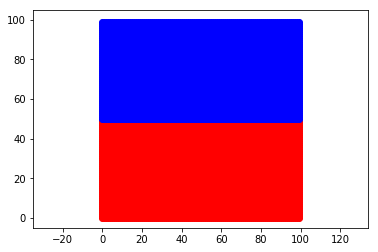

In [15]:
data_x, data_y, shape = extract_data('two_blocks_tb.txt', num_labels)

# Randomly take 9000 pixels to test on. The training set is only 1000
train_x, train_y, test_x, test_y = create_training_and_testing_sets(data_x, data_y, shape, 9000)
draw_image(data_x)

In [16]:
for i in range(20):
    print("Iteration: ", i )
    x, y, init, train_op, loss, accuracy, prediction = build_model()
    run(x, y, init, train_op, loss, accuracy, data_x, data_y, data_x, data_y, prediction)

Iteration:  0
loss: 1.3759518
loss: 0.40943286
Training Accuracy: 0.9109
Testing Accuracy: 0.9109
Iteration:  1
loss: 1.4012954
loss: 0.4052122
Training Accuracy: 0.9841
Testing Accuracy: 0.9841
Iteration:  2
loss: 1.3643445
loss: 0.41513208
Training Accuracy: 0.9095
Testing Accuracy: 0.9095
Iteration:  3
loss: 1.3822191
loss: 0.4056404
Training Accuracy: 0.984
Testing Accuracy: 0.984
Iteration:  4
loss: 1.3952708
loss: 0.4036928
Training Accuracy: 0.9851
Testing Accuracy: 0.9851
Iteration:  5
loss: 1.3947557
loss: 0.40357408
Training Accuracy: 0.9841
Testing Accuracy: 0.9841
Iteration:  6
loss: 1.4056766
loss: 0.40380317
Training Accuracy: 0.9847
Testing Accuracy: 0.9847
Iteration:  7
loss: 1.3674237
loss: 0.41721475
Training Accuracy: 0.9114
Testing Accuracy: 0.9114
Iteration:  8
loss: 1.3716996
loss: 0.4031547
Training Accuracy: 0.985
Testing Accuracy: 0.985
Iteration:  9
loss: 1.3804631
loss: 0.40487382
Training Accuracy: 0.9836
Testing Accuracy: 0.9836
Iteration:  10
loss: 1.39212

Diagonal:

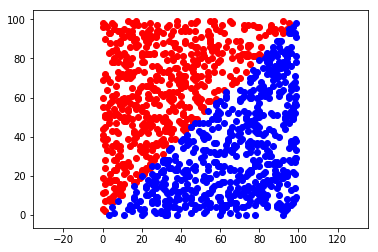

In [140]:
data_x, data_y, shape = extract_data('two_blocks_diag.txt', num_labels)

# Randomly take 9000 pixels to test on. The training set is only 1000
train_x, train_y, test_x, test_y = create_training_and_testing_sets(data_x, data_y, shape, 9000)
draw_image(train_x)

In [142]:
for i in range(20):
    print("Iteration: ", i )
    x, y, init, train_op, loss, accuracy, prediction = build_model()
    run(x, y, init, train_op, loss, accuracy,train_x, train_y, test_x, test_y, prediction )

Iteration:  0
loss: 1.3507522
loss: 0.060109925
Training Accuracy: 0.9881818
Testing Accuracy: 0.9892222
Iteration:  1
loss: 1.4207096
loss: 0.062251836
Training Accuracy: 0.9881818
Testing Accuracy: 0.9902222
Iteration:  2
loss: 1.3802321
loss: 0.05985636
Training Accuracy: 0.9881818
Testing Accuracy: 0.98933333
Iteration:  3
loss: 1.387581
loss: 0.059598334
Training Accuracy: 0.9881818
Testing Accuracy: 0.9892222
Iteration:  4
loss: 1.4081017
loss: 0.05959494
Training Accuracy: 0.9881818
Testing Accuracy: 0.9892222
Iteration:  5
loss: 1.3832333
loss: 0.05958324
Training Accuracy: 0.9881818
Testing Accuracy: 0.98933333
Iteration:  6
loss: 1.4039774
loss: 0.05968848
Training Accuracy: 0.9881818
Testing Accuracy: 0.9892222
Iteration:  7
loss: 1.3709445
loss: 0.06225088
Training Accuracy: 0.9881818
Testing Accuracy: 0.9901111
Iteration:  8
loss: 1.3997668
loss: 0.05988766
Training Accuracy: 0.9881818
Testing Accuracy: 0.9892222
Iteration:  9
loss: 1.3878275
loss: 0.062123545
Training Acc

We next tried a image where the number of red and blue dots was not the same.

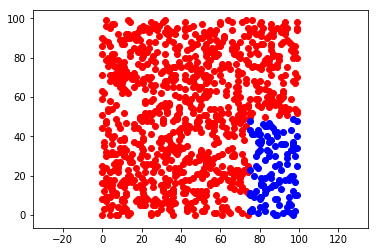

Iteration:  0
loss: 1.3838674
loss: 0.34129062
Training Accuracy: 0.948
Testing Accuracy: 0.94155556
9000
[[ 0  0 16 35  0]
 [ 0  0 75 32  1]
 [ 0  0 91 11  1]
 ...
 [ 0  0 79 83  0]
 [ 0  0 18 16  0]
 [ 0  0 66 77  0]]


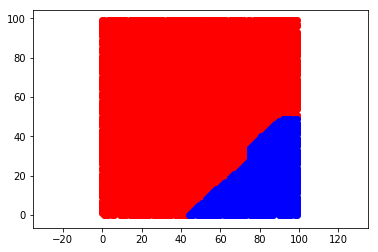

In [51]:
data_x, data_y, shape = extract_data('corner_color.txt', num_labels)

# Randomly take 9000 pixels to test on. The training set is only 1000
train_x, train_y, test_x, test_y = create_training_and_testing_sets(data_x, data_y, shape, 9000)
draw_image(train_x)

for i in range(1):
    print("Iteration: ", i )
    x, y, init, train_op, loss, accuracy, prediction = build_model()
    prediction = run(x, y, init, train_op, loss, accuracy, train_x, train_y, test_x, test_y, prediction )
    draw_prediction(test_x, prediction)

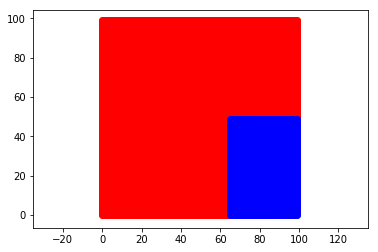

Iteration:  0
loss: 1.389751
loss: 0.3486269
Training Accuracy: 0.9313
Testing Accuracy: 0.9313
10000
[[ 0  0  0  0  0]
 [ 0  0  0  1  0]
 [ 0  0  0  2  0]
 ...
 [ 0  0 99 47  1]
 [ 0  0 99 48  1]
 [ 0  0 99 49  0]]


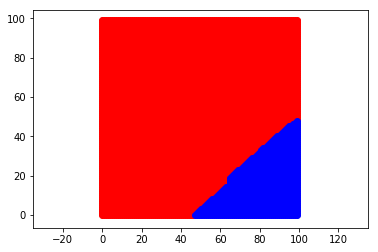

In [65]:
data_x, data_y, shape = extract_data('corner_color.txt', num_labels)

# Randomly take 9000 pixels to test on. The training set is only 1000
train_x, train_y, test_x, test_y = create_training_and_testing_sets(data_x, data_y, shape, 9000)
draw_image(data_x)

for i in range(1):
    print("Iteration: ", i )
    x, y, init, train_op, loss, accuracy, prediction = build_model()
    prediction = run(x, y, init, train_op, loss, accuracy, data_x, data_y, data_x, data_y, prediction )
    draw_prediction(data_x, prediction)

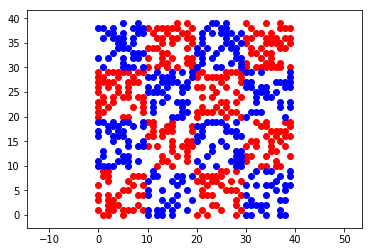

Iteration:  0
loss: 1.3874474
loss: 0.9931606
Training Accuracy: 1.0
Testing Accuracy: 1.0
Iteration:  1
loss: 1.3888959
loss: 1.0548548
Training Accuracy: 1.0
Testing Accuracy: 1.0
Iteration:  2
loss: 1.3910882
loss: 1.0633695
Training Accuracy: 1.0
Testing Accuracy: 1.0
Iteration:  3
loss: 1.3840473
loss: 1.0516864
Training Accuracy: 1.0
Testing Accuracy: 1.0
Iteration:  4
loss: 1.3901113
loss: 1.0023196
Training Accuracy: 1.0
Testing Accuracy: 1.0
Iteration:  5
loss: 1.3884748
loss: 0.99569845
Training Accuracy: 0.96666664
Testing Accuracy: 0.974
Iteration:  6
loss: 1.3858262
loss: 1.0016807
Training Accuracy: 1.0
Testing Accuracy: 1.0
Iteration:  7
loss: 1.3877584
loss: 0.9996063
Training Accuracy: 1.0
Testing Accuracy: 1.0
Iteration:  8
loss: 1.3863953
loss: 1.0598629
Training Accuracy: 1.0
Testing Accuracy: 1.0
Iteration:  9
loss: 1.3862959
loss: 1.0623719
Training Accuracy: 1.0
Testing Accuracy: 1.0
Iteration:  10
loss: 1.3860385
loss: 1.041093
Training Accuracy: 1.0
Testing Acc

In [144]:
data_x, data_y, shape = extract_data('checkerboard_big.txt', num_labels)

# Randomly take 1000 pixels to test on. The training set is only 600
train_x, train_y, test_x, test_y = create_training_and_testing_sets(data_x, data_y, shape, 1000)
draw_image(train_x)

for i in range(20):
    print("Iteration: ", i )
    x, y, init, train_op, loss, accuracy, prediction = build_model()
    run(x, y, init, train_op, loss, accuracy, train_x, train_y, test_x, test_y, prediction )

The checkerboard seems to be really easy and gets 100% accuracy almost all the time, even though it is more complicated than the other patterns.

We then tested a checkerboard that had gaps within it and it still had extremely good results.

800


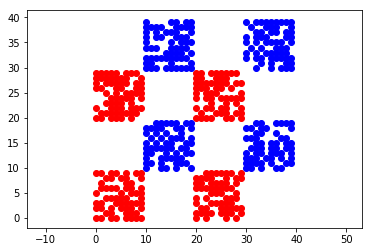

Iteration:  0
loss: 1.3904954
loss: 0.61919725
Training Accuracy: 0.986
Testing Accuracy: 0.99333334
Iteration:  1
loss: 1.388801
loss: 0.76798856
Training Accuracy: 0.848
Testing Accuracy: 0.85
Iteration:  2
loss: 1.38734
loss: 0.6191046
Training Accuracy: 0.986
Testing Accuracy: 0.99
Iteration:  3
loss: 1.3761032
loss: 0.78183377
Training Accuracy: 0.858
Testing Accuracy: 0.87333333
Iteration:  4
loss: 1.3865979
loss: 0.61821645
Training Accuracy: 0.986
Testing Accuracy: 0.99
Iteration:  5
loss: 1.3824471
loss: 0.6270792
Training Accuracy: 0.988
Testing Accuracy: 0.99333334
Iteration:  6
loss: 1.3797973
loss: 0.7810064
Training Accuracy: 0.86
Testing Accuracy: 0.87333333
Iteration:  7
loss: 1.3913155
loss: 0.6172248
Training Accuracy: 0.986
Testing Accuracy: 0.99
Iteration:  8
loss: 1.3870474
loss: 0.7721905
Training Accuracy: 0.86
Testing Accuracy: 0.87333333
Iteration:  9
loss: 1.3806859
loss: 0.61035556
Training Accuracy: 1.0
Testing Accuracy: 1.0
Iteration:  10
loss: 1.3949951
lo

In [150]:
data_x, data_y, shape = extract_data('checkerboard_weird.txt', num_labels)
print(shape)
# Randomly take 300 pixels to test on. The training set is only 500
train_x, train_y, test_x, test_y = create_training_and_testing_sets(data_x, data_y, shape, 300 )
draw_image(train_x)

for i in range(20):
    print("Iteration: ", i )
    x, y, init, train_op, loss, accuracy, prediction = build_model()
    run(x, y, init, train_op, loss, accuracy, train_x, train_y, test_x, test_y, prediction )

We tried one more time with a 50x50 square in the middle of a bunch of other points. 

10000


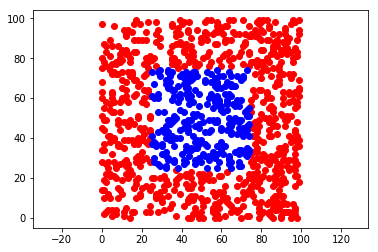

Iteration:  0
loss: 1.3804561
loss: 1.092165
Training Accuracy: 0.949
Testing Accuracy: 0.95255554
<class 'list'>
Iteration:  1
loss: 1.3998913
loss: 1.0906624
Training Accuracy: 0.954
Testing Accuracy: 0.95622224
<class 'list'>
Iteration:  2
loss: 1.3783342
loss: 1.0912303
Training Accuracy: 0.955
Testing Accuracy: 0.9576667
<class 'list'>
Iteration:  3
loss: 1.4057752
loss: 1.0918366
Training Accuracy: 0.951
Testing Accuracy: 0.9538889
<class 'list'>
Iteration:  4
loss: 1.3697872
loss: 1.11201
Training Accuracy: 0.734
Testing Accuracy: 0.75177777
<class 'list'>
Iteration:  5
loss: 1.3722929
loss: 1.091939
Training Accuracy: 0.95
Testing Accuracy: 0.9533333
<class 'list'>
Iteration:  6
loss: 1.3893324
loss: 1.1127483
Training Accuracy: 0.734
Testing Accuracy: 0.75177777
<class 'list'>
Iteration:  7
loss: 1.3809677
loss: 1.1153091
Training Accuracy: 0.734
Testing Accuracy: 0.75177777
<class 'list'>
Iteration:  8
loss: 1.3904966
loss: 1.1126634
Training Accuracy: 0.734
Testing Accuracy:

In [35]:
data_x, data_y, shape = extract_data('block_in_middle.txt', num_labels)
print(shape)
# Randomly take 9000 pixels to test on. The training set is only 1000
train_x, train_y, test_x, test_y = create_training_and_testing_sets(data_x, data_y, shape, 9000 )
draw_image(train_x)

for i in range(20):
    print("Iteration: ", i )
    x, y, init, train_op, loss, accuracy, prediction = build_model()
    prediction = run(x, y, init, train_op, loss, accuracy, train_x, train_y, test_x, test_y, prediction )
    print(type(prediction))
    #draw_prediction(test_x, prediction)

Our testing and training accuracy fluctuated a lot more and was always between 75% and 90%. Increasing the amount of training data points did not help.

10000


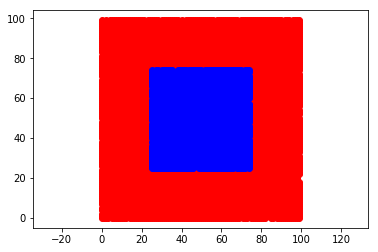

Iteration:  0
loss: 1.3938221
loss: 1.0832794
Training Accuracy: 0.7508889
Testing Accuracy: 0.742
Tensor("Softmax_10:0", shape=(?, 2), dtype=float32)
[[0.94396603 0.05603398]
 [0.9062357  0.09376425]
 [0.9112285  0.08877148]
 ...
 [0.7994137  0.20058635]
 [0.90838695 0.09161303]
 [0.8126671  0.18733297]]
Iteration:  1
loss: 1.378022
loss: 1.0818646
Training Accuracy: 0.7508889
Testing Accuracy: 0.742
Tensor("Softmax_11:0", shape=(?, 2), dtype=float32)
[[0.9451774  0.05482262]
 [0.9076033  0.09239665]
 [0.9125933  0.08740668]
 ...
 [0.7993634  0.20063664]
 [0.9097252  0.09027481]
 [0.81278753 0.1872124 ]]
Iteration:  2
loss: 1.3999164
loss: 1.08141
Training Accuracy: 0.7508889
Testing Accuracy: 0.742
Tensor("Softmax_12:0", shape=(?, 2), dtype=float32)
[[0.9456526  0.05434744]
 [0.90811914 0.09188082]
 [0.91311145 0.08688856]
 ...
 [0.79930526 0.20069471]
 [0.9102298  0.08977019]
 [0.8128062  0.18719375]]
Iteration:  3
loss: 1.3840909
loss: 1.0577888
Training Accuracy: 0.90855557
Testin

In [33]:
data_x, data_y, shape = extract_data('block_in_middle.txt', num_labels)
print(shape)
# Randomly take 1000 pixels to test on. The training set is only 9000
train_x, train_y, test_x, test_y = create_training_and_testing_sets(data_x, data_y, shape, 1000 )
draw_image(train_x)

for i in range(20):
    print("Iteration: ", i )
    x, y, init, train_op, loss, accuracy, prediction = build_model()
    run(x, y, init, train_op, loss, accuracy, train_x, train_y, test_x, test_y, prediction )

10000


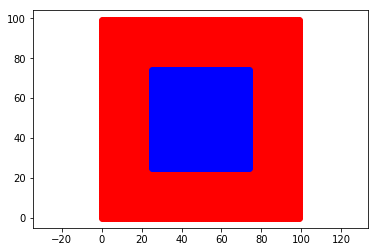

Iteration:  0
loss: 1.3914146
loss: 1.1246738
Training Accuracy: 0.75
Testing Accuracy: 0.75
10000
[[ 0  0 25 25  0]
 [ 0  0 25 26  0]
 [ 0  0 25 27  0]
 ...
 [ 0  0 99 97  0]
 [ 0  0 99 98  0]
 [ 0  0 99 99  0]]


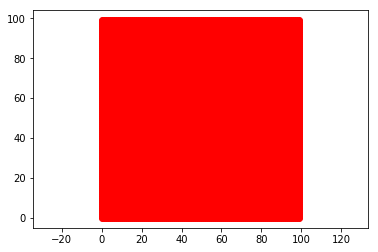

In [100]:
data_x, data_y, shape = extract_data('block_in_middle.txt', num_labels)
print(shape)
# whole image
draw_image(data_x)

for i in range(1):
    print("Iteration: ", i )
    x, y, init, train_op, loss, accuracy, prediction = build_model()
    prediction = run(x, y, init, train_op, loss, accuracy, data_x, data_y, data_x, data_y, prediction )
    #print(prediction)
    #print(type(prediction))
    draw_prediction(data_x, prediction)

10000


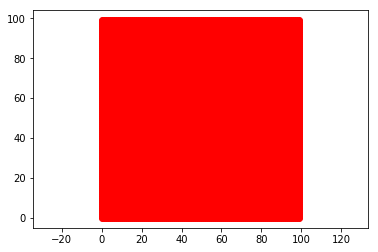

Iteration:  0
loss: 1.3893625
loss: 1.124552
Training Accuracy: 0.75
Testing Accuracy: 0.75
Tensor("Softmax_116:0", shape=(?, 2), dtype=float32)
[[0.6672949  0.33270505]
 [0.6672949  0.33270505]
 [0.6672949  0.33270505]
 ...
 [0.6672949  0.33270505]
 [0.6672949  0.33270505]
 [0.6672949  0.33270505]]
10000
[[ 0  0 25 25  0]
 [ 0  0 25 26  0]
 [ 0  0 25 27  0]
 ...
 [ 0  0 99 97  0]
 [ 0  0 99 98  0]
 [ 0  0 99 99  0]]


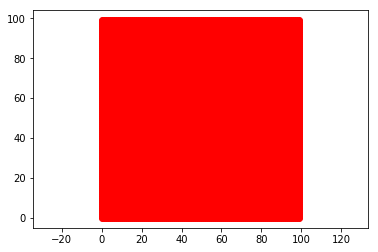

In [72]:
data_x, data_y, shape = extract_data('block_in_middle_nocolor.txt', num_labels)
print(shape)
# Randomly take 1000 pixels to test on. The training set is only 9000
train_x, train_y, test_x, test_y = create_training_and_testing_sets(data_x, data_y, shape, 1000 )
draw_image(data_x)

for i in range(1):
    print("Iteration: ", i )
    x, y, init, train_op, loss, accuracy, prediction = build_model()
    prediction = run(x, y, init, train_op, loss, accuracy, data_x, data_y, data_x, data_y, prediction )
    draw_prediction(data_x, prediction)

10000


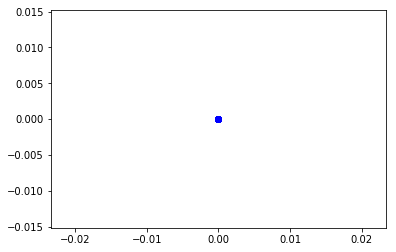

Iteration:  0
loss: 1.368976
loss: 1.1300067
Training Accuracy: 0.74755555
Testing Accuracy: 0.772
Iteration:  1
loss: 1.3755953
loss: 1.1300036
Training Accuracy: 0.74755555
Testing Accuracy: 0.772
Iteration:  2
loss: 1.404613
loss: 1.1299535
Training Accuracy: 0.74755555
Testing Accuracy: 0.772
Iteration:  3
loss: 1.3995199
loss: 1.1300161
Training Accuracy: 0.74755555
Testing Accuracy: 0.772
Iteration:  4
loss: 1.3808221
loss: 1.1300079
Training Accuracy: 0.74755555
Testing Accuracy: 0.772
Iteration:  5
loss: 1.3997048
loss: 1.1300087
Training Accuracy: 0.74755555
Testing Accuracy: 0.772
Iteration:  6
loss: 1.3431556
loss: 1.1296762
Training Accuracy: 0.74755555
Testing Accuracy: 0.772
Iteration:  7
loss: 1.3997207
loss: 1.1278135
Training Accuracy: 0.74755555
Testing Accuracy: 0.772
Iteration:  8
loss: 1.324683
loss: 1.1300031
Training Accuracy: 0.74755555
Testing Accuracy: 0.772
Iteration:  9
loss: 1.385318
loss: 1.1252228
Training Accuracy: 0.74755555
Testing Accuracy: 0.772
Iter

In [30]:
data_x, data_y, shape = extract_data('block_in_middle_noxy.txt', num_labels)
print(shape)
# Randomly take 1000 pixels to test on. The training set is only 9000
train_x, train_y, test_x, test_y = create_training_and_testing_sets(data_x, data_y, shape, 1000 )
draw_image(train_x)

for i in range(20):
    print("Iteration: ", i )
    x, y, init, train_op, loss, accuracy, prediction = build_model()
    run(x, y, init, train_op, loss, accuracy, data_x, data_y, data_x, data_y, prediction )

10000


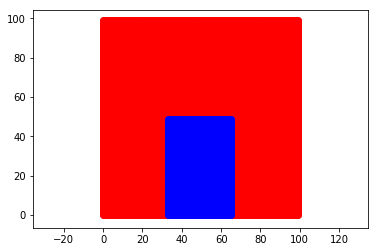

Iteration:  0
loss: 0.68665946
loss: 0.37445372
Training Accuracy: 0.8307
Testing Accuracy: 0.8307
10000
[[ 0  0 33  0  0]
 [ 0  0 33  1  0]
 [ 0  0 33  2  0]
 ...
 [ 0  0 99 47  0]
 [ 0  0 99 48  0]
 [ 0  0 99 49  0]]


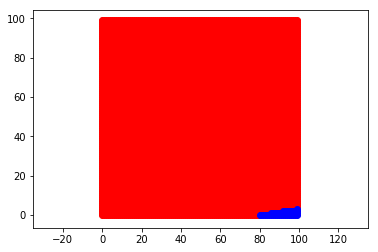

In [85]:
data_x, data_y, shape = extract_data('block_in_middle_simple.txt', num_labels)
print(shape)
train_x, train_y, test_x, test_y = create_training_and_testing_sets(data_x, data_y, shape, 1000 )
draw_image(data_x)

for i in range(1):
    print("Iteration: ", i )
    x, y, init, train_op, loss, accuracy, prediction = build_model()
    prediction = run(x, y, init, train_op, loss, accuracy, data_x, data_y, data_x, data_y, prediction )
    draw_prediction(data_x, prediction)

#TO DO#
When doing the real data, user id is kinda useless. You want to have a vector instead that is the embedding of the user, such as interactions of the user and information about the user. Maybe the top projects they participated in or their relation to other users.
TAke a small sample square of the data with a few pictures in it.
Read the paper and make it better
Clean and organize the notebook

If i given all the updates, how do i cluster them so that they form the images
EX: from 10000 updates, 100 images were built. Then i will train my model and be able to tell if it can perfectly find the images

Try to print out the weights. Look at the berkeely example and the cmu video again.